In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

%matplotlib inline

In [2]:
files = ['turnstile_160402.csv',
         'turnstile_160409.csv',
         'turnstile_160416.csv',
         'turnstile_160423.csv',
         'turnstile_160430.csv',
         'turnstile_160507.csv',
         'turnstile_160514.csv',
         'turnstile_160521.csv',
         'turnstile_160528.csv', 
         'turnstile_160604.csv',
         'turnstile_160611.csv',
         'turnstile_160618.csv', 
         'turnstile_160625.csv']

mta = pd.DataFrame()
frames = []

# Read in all data files to a list
for f in files:
    df = pd.read_csv(f)
    frames.append(df)

# Append all the files together
mta = pd.concat(frames)
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,04:00:00,REGULAR,5595746,1893282
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,08:00:00,REGULAR,5595746,1893282
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,12:00:00,REGULAR,5595746,1893282
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,16:00:00,REGULAR,5595746,1893282


In [3]:
# Clean up column names
mta.columns = [n.lower().strip() for n in mta.columns]

# Add column with date and time as datetime object
mta['date_time'] = mta['date'] + " " + mta['time']
mta.date_time = pd.to_datetime(mta.date_time, format='%m/%d/%Y %H:%M:%S')
mta.head(10)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277,2016-03-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,04:00:00,REGULAR,5595746,1893282,2016-03-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,08:00:00,REGULAR,5595746,1893282,2016-03-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,12:00:00,REGULAR,5595746,1893282,2016-03-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,16:00:00,REGULAR,5595746,1893282,2016-03-26 16:00:00
5,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,20:00:00,REGULAR,5595746,1893282,2016-03-26 20:00:00
6,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,00:00:00,REGULAR,5595746,1893282,2016-03-27 00:00:00
7,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,04:00:00,REGULAR,5595746,1893282,2016-03-27 04:00:00
8,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,08:00:00,REGULAR,5595746,1893282,2016-03-27 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,12:00:00,REGULAR,5595746,1893282,2016-03-27 12:00:00


In [4]:
# Check for duplicates
mta.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date_time'])\
            .size().sort_values(ascending=False).value_counts()


1    2523464
2         51
dtype: int64

In [5]:
# Sort by date and time
mta.sort_values(['c/a', 'unit', 'scp', 'station', 'linename', 'date_time'],\
                inplace=True, ascending=False)

# Remove duplicates
mta.drop_duplicates(subset=['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True)

# Sanity check for duplicates
mta.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date_time'])\
            .size().sort_values(ascending=False).value_counts()


1    2523515
dtype: int64

In [6]:
#Sort by date and time
mta.sort_values('date_time', inplace = True)

# Calculate total entires and exits
mta['ent_diff'] = mta.groupby(['c/a', 'unit', 'scp', 'station', 'linename'])\
                .entries.transform(lambda x: abs(x - x.shift()))

mta['ex_diff'] = mta.groupby(['c/a', 'unit', 'scp', 'station', 'linename'])\
                .exits.transform(lambda x: abs(x - x.shift()))
mta.head(10)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,ent_diff,ex_diff
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277,2016-03-26,NaN,NaN
64672,N129,R382,00-03-01,GRANT AV,A,IND,03/26/2016,00:00:00,REGULAR,9026227,6571299,2016-03-26,NaN,NaN
66197,N141,R356,00-00-04,OZONE PK LEFFRT,A,IND,03/26/2016,00:00:00,REGULAR,5028288,2149106,2016-03-26,NaN,NaN
54893,N086,R282,00-00-02,SPRING ST,CE,IND,03/26/2016,00:00:00,REGULAR,337791552,84416229,2016-03-26,NaN,NaN
181094,R533,R055,00-03-07,FLUSHING-MAIN,7,IRT,03/26/2016,00:00:00,REGULAR,470447,251614,2016-03-26,NaN,NaN
69011,N195,R358,00-00-02,BEACH 25 ST,A,IND,03/26/2016,00:00:00,REGULAR,1670175,974583,2016-03-26,NaN,NaN
53160,N076,R111,00-00-01,23 ST,CE,IND,03/26/2016,00:00:00,REGULAR,8595576,4790479,2016-03-26,NaN,NaN
19842,C008,R099,00-00-02,DEKALB AV,BDNQR,BMT,03/26/2016,00:00:00,REGULAR,10081426,8510226,2016-03-26,NaN,NaN
129848,R155,R116,01-00-03,50 ST,1,IRT,03/26/2016,00:00:00,REGULAR,1073823,448263,2016-03-26,NaN,NaN
30203,H009,R235,00-03-01,BEDFORD AV,L,BMT,03/26/2016,00:00:00,REGULAR,15391399,19330813,2016-03-26,NaN,NaN


In [7]:
# Add traffic column (aggregate of entires and exits)
mta['traffic'] = mta.ent_diff + mta.ex_diff

# Sort
mta.sort_values(['c/a', 'unit', 'scp', 'station', 'linename', 'date_time'], inplace=True)

mta.head(10)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,ent_diff,ex_diff,traffic
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277,2016-03-26 00:00:00,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,04:00:00,REGULAR,5595746,1893282,2016-03-26 04:00:00,0.0,5.0,5.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,08:00:00,REGULAR,5595746,1893282,2016-03-26 08:00:00,0.0,0.0,0.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,12:00:00,REGULAR,5595746,1893282,2016-03-26 12:00:00,0.0,0.0,0.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,16:00:00,REGULAR,5595746,1893282,2016-03-26 16:00:00,0.0,0.0,0.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,20:00:00,REGULAR,5595746,1893282,2016-03-26 20:00:00,0.0,0.0,0.0
6,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,00:00:00,REGULAR,5595746,1893282,2016-03-27 00:00:00,0.0,0.0,0.0
7,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,04:00:00,REGULAR,5595746,1893282,2016-03-27 04:00:00,0.0,0.0,0.0
8,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,08:00:00,REGULAR,5595746,1893282,2016-03-27 08:00:00,0.0,0.0,0.0
9,A002,R051,02-00-00,59 ST,NQR456,BMT,03/27/2016,12:00:00,REGULAR,5595746,1893282,2016-03-27 12:00:00,0.0,0.0,0.0


Some turnstile values are obvious errors, we need to figure out what is a reasonable amount of traffic per turnstile. We decided to look at the values for the most heavily trafficked station, Time Square.

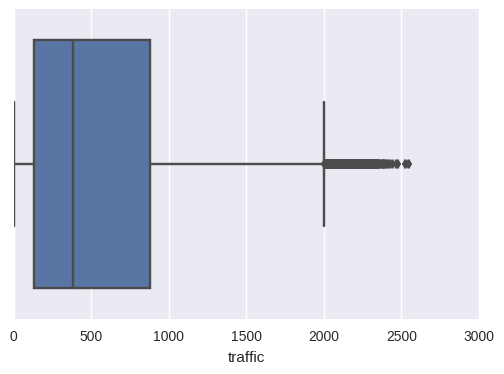

In [8]:
# Subset Time Square data and plot boxplot of traffic
time_sq = mta[(mta.station == 'TIMES SQ-42 ST')]
sns.boxplot(time_sq.traffic[time_sq.traffic < 100000])

In [9]:
# Subset our data to include only turnstiles less than 3000
mta3000 = mta[(mta.traffic < 3000) ]

# Print tail to check traffic values are correct
mta3000.sort_values(['traffic']).tail()


,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,ent_diff,ex_diff,traffic
95671,N506,R022,00-00-00,34 ST-HERALD SQ,BDFMNQR,IND,05/23/2016,20:00:00,REGULAR,4137036,6672955,2016-05-23 20:00:00,1757.0,1240.0,2997.0
154123,R249,R179,01-00-09,86 ST,456,IRT,04/04/2016,12:00:00,REGULAR,1183712,11522439,2016-04-04 12:00:00,102.0,2895.0,2997.0
149574,R238,R046,00-03-04,GRD CNTRL-42 ST,4567S,IRT,06/14/2016,20:00:00,REGULAR,9236584,9879642,2016-06-14 20:00:00,2140.0,858.0,2998.0
154281,R249,R179,01-00-09,86 ST,456,IRT,04/20/2016,12:00:00,REGULAR,1200700,11674670,2016-04-20 12:00:00,117.0,2882.0,2999.0
157596,R258,R132,00-00-02,125 ST,456,IRT,05/23/2016,17:00:00,REGULAR,2628377,18614742,2016-05-23 17:00:00,1909.0,1090.0,2999.0


Now we want to aggregate all the turnstile data for each station and line together so that we can see the total foot traffic for each station. 

In [10]:
mta_traffic = mta3000.groupby(['station', 'linename', 'date_time'], as_index=False)\
              [['traffic']].sum()
mta_traffic.head(10)

,station,linename,date_time,traffic
0,1 AV,L,2016-03-26 04:00:00,3137.0
1,1 AV,L,2016-03-26 08:00:00,1504.0
2,1 AV,L,2016-03-26 12:00:00,5502.0
3,1 AV,L,2016-03-26 16:00:00,8825.0
4,1 AV,L,2016-03-26 20:00:00,10846.0
5,1 AV,L,2016-03-27 00:00:00,8617.0
6,1 AV,L,2016-03-27 04:00:00,2996.0
7,1 AV,L,2016-03-27 08:00:00,1011.0
8,1 AV,L,2016-03-27 12:00:00,4279.0
9,1 AV,L,2016-03-27 16:00:00,7125.0


In [11]:
# Add date column
mta_traffic['date'] = mta_traffic.date_time.apply(lambda x: x.date())


In [12]:
# Total traffic per Station for each day
daily_traffic = mta_traffic.groupby(['station', 'linename', 'date'], as_index=False)[['traffic']].\
                sum().sort_values('traffic', ascending= False)

print daily_traffic.traffic.describe()
daily_traffic.head(10)


count     42801.000000
mean      19289.095045
std       24770.383982
min           0.000000
25%        6188.000000
50%       11472.000000
75%       22239.000000
max      282012.000000
Name: traffic, dtype: float64


,station,linename,date,traffic
28124,GRD CNTRL-42 ST,4567S,2016-03-31,282012.0
28123,GRD CNTRL-42 ST,4567S,2016-03-30,279249.0
28122,GRD CNTRL-42 ST,4567S,2016-03-29,277801.0
28193,GRD CNTRL-42 ST,4567S,2016-06-08,276619.0
28157,GRD CNTRL-42 ST,4567S,2016-05-03,275709.0
28207,GRD CNTRL-42 ST,4567S,2016-06-22,273699.0
28160,GRD CNTRL-42 ST,4567S,2016-05-06,272946.0
28178,GRD CNTRL-42 ST,4567S,2016-05-24,270013.0
28180,GRD CNTRL-42 ST,4567S,2016-05-26,269132.0
28187,GRD CNTRL-42 ST,4567S,2016-06-02,268554.0


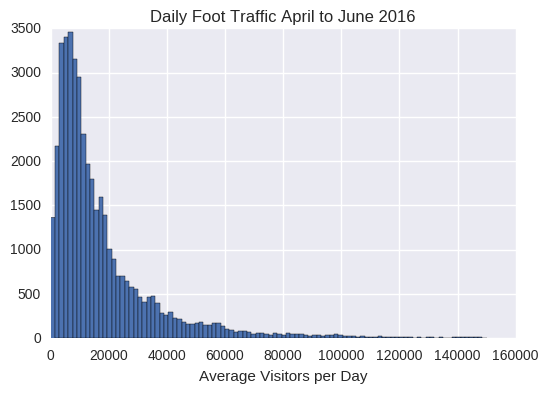

In [13]:
plt.hist(daily_traffic.traffic, bins=100, range=(0,150000));
plt.title("Daily Foot Traffic April to June 2016")
plt.xlabel("Average Visitors per Day")


In [14]:
# Calculate average daily traffic per station
avg_daily_traffic = mta_traffic.groupby(['station', 'linename', 'date'], as_index=False)[['traffic']].\
                    sum().sort_values('traffic', ascending= False)

avg_daily_traffic = avg_daily_traffic.groupby(['station', 'linename'], as_index=False)[['traffic']].mean().\
                    sort_values('traffic', ascending=False).reset_index()

avg_daily_traffic.head(50)

,index,station,linename,traffic
0,310,GRD CNTRL-42 ST,4567S,210072.670330
1,90,34 ST-HERALD SQ,BDFMNQR,201552.000000
2,445,TIMES SQ-42 ST,1237ACENQRS,144006.560440
3,94,34 ST-PENN STA,ACE,134450.989011
4,103,42 ST-PORT AUTH,ACENQRS1237,129871.505495
5,28,14 ST-UNION SQ,LNQR456,121234.978022
6,156,86 ST,456,103570.197802
7,107,47-50 STS ROCK,BDFM,101388.516484
8,287,FLUSHING-MAIN,7,98280.373626
9,126,59 ST COLUMBUS,ABCD1,91826.329670


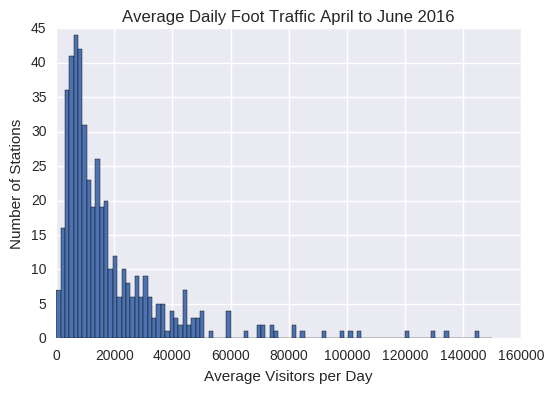

In [15]:
# Plot hist of Average Daily Traffic
plt.hist(avg_daily_traffic.traffic, bins=100, range=(0,150000));
plt.title("Average Daily Foot Traffic April to June 2016")
plt.ylabel("Number of Stations")
plt.xlabel("Average Visitors per Day")

Most trafficked stations will be too busy for canvassers to be able to engage people. Want to look at stations that are slightly less busy.

In [16]:
# Find upper and lower boundaries
low = avg_daily_traffic.traffic.quantile(.7)
high = avg_daily_traffic.traffic.quantile(.9)

# Subset data by the boundries
daily_mean_for_merge = avg_daily_traffic[(avg_daily_traffic.traffic >= low) & (avg_daily_traffic.traffic <= high)]
daily_mean_for_merge.head(10)

,index,station,linename,traffic
48,175,ATL AV-BARCLAY,BDNQR2345,41608.945055
49,131,66 ST-LINCOLN,1,40710.615385
50,82,28 ST,6,40149.857143
51,440,SUTPHIN-ARCHER,EJZ,39479.659341
52,116,51 ST,6,39458.800000
53,148,8 AV,ACEL,39332.362637
54,306,GRAND ST,BD,38733.846154
55,241,CHAMBERS ST,123,37228.945055
56,291,FOREST HILLS 71,EFMR,37169.747253
57,24,14 ST,123FLM,37064.637363


In [17]:
# Add hours column for graph
mta_traffic['hour'] = mta_traffic.date_time.apply(lambda x: x.hour)
mta_traffic.head(10)

,station,linename,date_time,traffic,date,hour
0,1 AV,L,2016-03-26 04:00:00,3137.0,2016-03-26,4
1,1 AV,L,2016-03-26 08:00:00,1504.0,2016-03-26,8
2,1 AV,L,2016-03-26 12:00:00,5502.0,2016-03-26,12
3,1 AV,L,2016-03-26 16:00:00,8825.0,2016-03-26,16
4,1 AV,L,2016-03-26 20:00:00,10846.0,2016-03-26,20
5,1 AV,L,2016-03-27 00:00:00,8617.0,2016-03-27,0
6,1 AV,L,2016-03-27 04:00:00,2996.0,2016-03-27,4
7,1 AV,L,2016-03-27 08:00:00,1011.0,2016-03-27,8
8,1 AV,L,2016-03-27 12:00:00,4279.0,2016-03-27,12
9,1 AV,L,2016-03-27 16:00:00,7125.0,2016-03-27,16


In [18]:
# Get average hourly traffic per station for entire period
hourly_traffic = mta_traffic.groupby(['station', 'linename', 'hour'], as_index=False)\
     [['traffic']].mean()
hourly_traffic['name'] = hourly_traffic.station + ' ' + hourly_traffic.linename
hourly_traffic.head(10)

,station,linename,hour,traffic,name
0,1 AV,L,0,8090.744444,1 AV L
1,1 AV,L,4,1785.780220,1 AV L
2,1 AV,L,7,2490.833333,1 AV L
3,1 AV,L,8,3843.635417,1 AV L
4,1 AV,L,9,3284.200000,1 AV L
5,1 AV,L,10,874.500000,1 AV L
6,1 AV,L,12,9111.358696,1 AV L
7,1 AV,L,16,9153.131868,1 AV L
8,1 AV,L,20,12956.177778,1 AV L
9,103 ST,1,1,1790.402299,103 ST 1


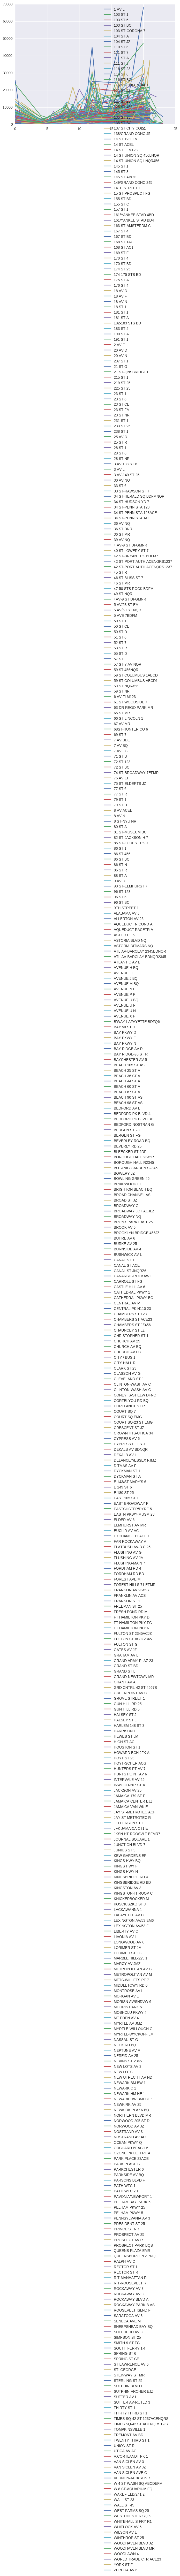

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
groups = hourly_traffic.groupby('name')
for name, gp in groups:
    ax.plot(gp.hour, gp.traffic, linestyle="-", ms=12, label=name)
ax.legend()


In [20]:
# Get unique list of stations
stations_df = mta_traffic.groupby(['station','linename']).head(1)
stations_df = stations_df.assign(join_station_line = stations_df.station + ' ' + stations_df.linename)
stations = stations_df['join_station_line']

In [21]:
# Read in income data
inc = pd.read_csv('income_by_subway_stops.csv')
inc.columns = [n.lower().replace(' ', '_') for n in inc.columns]

In [22]:
# Clean income data
inc = inc.dropna(subset=['stop_name']) # We don't have data for the Shuttle trains. We drop the nulls.

In [23]:
# Make a new column combining 'stop_name' with every 'subway_line' for that stop
inc.sort_values(['lat', 'long', 'subway_line'], inplace=True)
inc2 = inc.groupby(['lat','long']).head(1)
line_names = inc.groupby(['lat','long']).subway_line.agg(lambda x: ''.join(x)).tolist()
inc2 = inc2.assign(line_names = line_names)
inc2.head(20)

,subway_line,lat,long,county_name,position,income2011,income2000,stop_name,county,tract,tract_lookup,line_names
415,F,40.575929,-73.976747,Brooklyn,2.0,34984.0,25938.0,W 8 St.-New York Aquarium,47.0,35000.0,35000.0,FQ
604,Q,40.576234,-73.967561,Brooklyn,3.0,27161.0,19539.0,Ocean Parkway,47.0,36001.0,36001.0,Q
357,D,40.576900,-73.980846,Brooklyn,1.0,34984.0,25938.0,Coney Island-Stillwell Ave.,47.0,35000.0,35000.0,DFNQ
280,B,40.577986,-73.960258,Brooklyn,1.0,28398.0,18854.0,Brighton Beach,47.0,36200.0,36200.0,BQ
416,F,40.580576,-73.974443,Brooklyn,3.0,42514.0,28678.0,Neptune Ave.,47.0,35400.0,35400.0,F
281,B,40.585734,-73.954371,Brooklyn,2.0,33616.0,29405.0,Sheepshead Bay,47.0,60600.0,60600.0,BQ
358,D,40.588066,-73.983498,Brooklyn,2.0,47019.0,32670.0,Bay 50 St.,47.0,30800.0,30800.0,D
417,F,40.590266,-73.974051,Brooklyn,4.0,43929.0,26129.0,Ave. X,47.0,38600.0,38600.0,F
249,A,40.591166,-73.796173,Queens,6.0,46210.0,40219.0,Beach 67 St.,81.0,95400.0,95400.0,A
248,A,40.592292,-73.789153,Queens,5.0,69209.0,46445.0,Beach 60 St.,81.0,96400.0,96400.0,A


In [24]:
# Run .upper on stop_name and combine with line_names
inc2 = inc2.assign(station_line = inc2.stop_name.str.upper() + ' ' + inc2.line_names)

# Check for multiple entries
print inc2.groupby('station_line').size().sort_values(ascending=False)[:10]  # We don't have any! ^_^
print inc2.shape

station_line
ZEREGA AVE. 6                          1
75 ST.-ELDERTS LN. JZ                  1
77 ST. R                               1
79 ST. 1                               1
79 ST. D                               1
8 AVE. N                               1
8 ST.-N.Y.U. NR                        1
80 ST. A                               1
81 ST.-MUSEUM OF NATURAL HISTORY BC    1
82 ST.-JACKSON HEIGHTS 7               1
dtype: int64
(428, 13)


In [25]:
# Find the station_line values in the 'stations' list that most closely match what is in inc2
inc2.loc[:,'join_station_line'] = inc2.station_line.apply(lambda x: difflib.get_close_matches(x, stations, n=1, cutoff=.3))
inc2.join_station_line = inc2.join_station_line.apply(lambda x: x[0])

In [26]:
# Check for duplicate join names
print inc2.sort_values('join_station_line').groupby('join_station_line').filter(lambda x: len(x) >1).loc[
    :,['income2011','station_line','join_station_line']]

# We have some duplicates and errors. Fix the ones that need fixing:
inc2.loc[441, 'join_station_line'] = '14 ST 123FLM'
inc2.loc[272, 'join_station_line'] = '125 ST ACBD'
inc2.loc[135, 'join_station_line'] = '3 AV 138 ST 6'
inc2.loc[365, 'join_station_line'] = 'NEW UTRECHT AV ND'
inc2.loc[224, 'join_station_line'] = '5 AVE 7BDFM'
inc2.loc[188, 'join_station_line'] = 'BLEECKER ST 6DF'
inc2.loc[615, 'join_station_line'] = 'BEVERLEY ROAD BQ'
inc2.loc[264, 'join_station_line'] = 'FULTON ST ACJZ2345'

print '\n', inc2.sort_values('join_station_line').groupby('join_station_line').filter(lambda x: len(x) >1).loc[
    :,['income2011','station_line','join_station_line']]
# This looks better. Next we'll drop the duplicates, taking the entry with higher income.

     income2011                           station_line      join_station_line
268     94292.0                    14 ST.-8TH AVE. ACE             14 ST ACEL
441    150110.0                      14 ST.-6 AVE. FLM             14 ST ACEL
510     85859.0                        14 ST.-8 AVE. L             14 ST ACEL
272     31875.0                           125 ST. ABCD            145 ST ABCD
273     38786.0                           145 ST. ABCD            145 ST ABCD
143     23029.0                              183 ST. 4               183 ST 4
135     16580.0                             138 ST. 45               183 ST 4
365     42350.0                               62 ST. D              36 ST DNR
370     31463.0                             36 ST. DNR              36 ST DNR
293     69250.0                42 ST.-BRYANT PARK BDFM  42 ST-BRYANT PK BDFM7
224    129625.0                   5 AVE.-BRYANT PARK 7  42 ST-BRYANT PK BDFM7
188    116250.0  BLEECKER ST.-BROADWAY-LAFAYETTE ST. 6  B'WAY-LA

In [27]:
# Drop dupes
inc2 = inc2.sort_values(['join_station_line', 'income2011'], ascending=False).groupby('join_station_line').head(1)
inc2.shape

(423, 14)

In [28]:
# Drop columns for merge
inc3 = inc2[['lat', 'long', 'county_name', 'income2011', 'join_station_line']]
inc3.head(20)

,lat,long,county_name,income2011,join_station_line
218,40.836954,-73.846653,the Bronx,43984.0,ZEREGA AV 6
435,40.701380,-73.986655,Brooklyn,167737.0,YORK ST F
393,40.713333,-74.009033,Manhattan,205192.0,WORLD TRADE CTR ACE23
148,40.886737,-73.878120,the Bronx,32889.0,WOODLAWN 4
566,40.733555,-73.869588,Queens,53750.0,WOODHAVEN BLVD MR
504,40.694077,-73.850476,Queens,55759.0,WOODHAVEN BLVD JZ
42,40.657184,-73.949976,Brooklyn,44444.0,WINTHROP ST 25
525,40.688805,-73.904741,Brooklyn,32658.0,WILSON AV L
212,40.827295,-73.886082,the Bronx,17614.0,WHITLOCK AV 6
653,40.701938,-74.012588,Manhattan,124048.0,WHITEHALL S-FRY R1


In [29]:
# Merge income and lat/long data into our subway traffic data
daily_mean_for_merge['join_station_line'] = daily_mean_for_merge.station + ' ' + daily_mean_for_merge.linename
daily_mean_merge = pd.merge(daily_mean_for_merge, inc3, how='left', on='join_station_line')

/home/ali/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
# Check result
print daily_mean_merge.shape
print daily_mean_merge.sort_values('income2011', na_position='first')     [['traffic', 'join_station_line', 'lat', 'income2011']][:20] # We have some nulls!

(94, 9)
         traffic            join_station_line        lat  income2011
0   41608.945055     ATL AV-BARCLAY BDNQR2345        NaN         NaN
5   39332.362637                    8 AV ACEL        NaN         NaN
16  35231.142857            THIRTY THIRD ST 1        NaN         NaN
18  33269.516484               GROVE STREET 1        NaN         NaN
20  32200.318681            PAVONIA/NEWPORT 1        NaN         NaN
35  29838.956044             JOURNAL SQUARE 1        NaN         NaN
48  27504.406593                 CITY / BUS 1        NaN         NaN
51  26125.340659             EXCHANGE PLACE 1        NaN         NaN
52  26120.076923   TIMES SQ-42 ST ACENQRS1237        NaN         NaN
57  25334.109890  42 ST-PORT AUTH ACENGRS1237        NaN         NaN
63  24112.377778                 59 ST NQR456        NaN         NaN
78  21138.439560                 MARCY AV JMZ  40.708788     16139.0
89  19940.945055           149/GRAND CONC 245  40.818405     16580.0
34  30058.109890          

In [31]:
# Manually fix a few join names
inc3 = inc3.append(inc3.loc[132])
inc3.iloc[423, 4] = '59 ST NQR456'

inc3 = inc3.append(inc3.loc[13])
inc3.iloc[424, 4] = 'TIMES SQ-42 ST ACENQRS1237'
inc3 = inc3.append(inc3.loc[13])
inc3.iloc[425, 4] = '42 ST-PORT AUTH ACENGRS1237'

inc3 = inc3.append(inc3.loc[268])
inc3.iloc[426, 4] = '8 AV ACEL'

inc3 = inc3.append(inc3.loc[49])
inc3.iloc[427, 4] = 'ATL AV-BARCLAY BDNQR2345'

In [32]:
# Join again and check results
daily_mean_merge = pd.merge(daily_mean_for_merge, inc3, how='left', on='join_station_line')

print daily_mean_merge.shape
print daily_mean_merge.sort_values('income2011', na_position='first')     [['traffic', 'join_station_line', 'lat', 'income2011']][:20] 
    
# Looks good. The remaining null are all the PATH trains. We'll drop those.
inc3.dropna(inplace=True)

(95, 9)
         traffic     join_station_line        lat  income2011
16  35231.142857     THIRTY THIRD ST 1        NaN         NaN
18  33269.516484        GROVE STREET 1        NaN         NaN
21  32200.318681     PAVONIA/NEWPORT 1        NaN         NaN
36  29838.956044      JOURNAL SQUARE 1        NaN         NaN
49  27504.406593          CITY / BUS 1        NaN         NaN
52  26125.340659      EXCHANGE PLACE 1        NaN         NaN
79  21138.439560          MARCY AV JMZ  40.708788     16139.0
90  19940.945055    149/GRAND CONC 245  40.818405     16580.0
35  30058.109890        3 AV-149 ST 25  40.816265     23670.0
91  19846.285714     116 ST-COLUMBIA 1  40.808245     26406.0
84  20411.197802              181 ST 1  40.849435     27324.0
55  25568.175824     137 ST CITY COL 1  40.821454     27477.0
94  19139.109890     BRIGHTON BEACH BQ  40.577986     28398.0
72  23207.461538              116 ST 6  40.798742     28567.0
89  20167.714286             36 ST DNR  40.654365     31463.0


In [33]:
daily_mean_merge.rename(columns={'income2011':'income'}, inplace=True)
daily_mean_merge.shape

(95, 9)

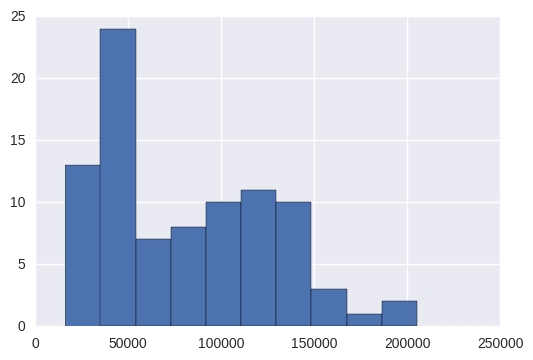

In [34]:
daily_mean_merge.income.hist()

In [35]:
daily_mean_merge.sort_values('income', ascending=False)

,index,station,linename,traffic,join_station_line,lat,long,county_name,income
7,241,CHAMBERS ST,123,37228.945055,CHAMBERS ST 123,40.715576,-74.009031,Manhattan,205192.0
87,471,WORLD TRADE CTR,ACE23,20241.263736,WORLD TRADE CTR ACE23,40.713333,-74.009033,Manhattan,205192.0
47,111,5 AV/59 ST,NQR,27740.263736,5 AV/59 ST NQR,40.764657,-73.972229,Manhattan,171000.0
31,232,CANAL ST,ACE,30734.065934,CANAL ST ACE,40.720758,-74.005399,Manhattan,164656.0
37,354,LEXINGTON AV/63,F,29809.846154,LEXINGTON AV/63 F,40.764881,-73.966411,Manhattan,152353.0
9,24,14 ST,123FLM,37064.637363,14 ST 123FLM,40.738678,-73.995632,Manhattan,150110.0
57,120,57 ST,F,25343.725275,57 ST F,40.764564,-73.976830,Manhattan,144659.0
1,131,66 ST-LINCOLN,1,40710.615385,66 ST-LINCOLN 1,40.773457,-73.982004,Manhattan,142452.0
38,171,ASTOR PL,6,29685.450549,ASTOR PL 6,40.730084,-73.990838,Manhattan,139236.0
44,150,8 ST-NYU,NR,28384.109890,8 ST-NYU NR,40.730385,-73.992182,Manhattan,139236.0


In [36]:
# Drop high-traffic stations that weren’t caught in the aggregate drop (since
# some stations were split into multiple)
daily_mean_merge.drop([59,39,65,58,53,0,19,20], inplace=True)

# Combine stations that were split into multiple that we want to keep
daily_mean_merge.loc[9, 'traffic'] += daily_mean_merge.loc[15, 'traffic']
daily_mean_merge.loc[5, 'traffic'] += daily_mean_merge.loc[17, 'traffic']
daily_mean_merge.drop([15, 17], inplace = True)

In [37]:
daily_mean_merge.sort_values('income', ascending=False).head(50)

,index,station,linename,traffic,join_station_line,lat,long,county_name,income
87,471,WORLD TRADE CTR,ACE23,20241.263736,WORLD TRADE CTR ACE23,40.713333,-74.009033,Manhattan,205192.0
7,241,CHAMBERS ST,123,37228.945055,CHAMBERS ST 123,40.715576,-74.009031,Manhattan,205192.0
47,111,5 AV/59 ST,NQR,27740.263736,5 AV/59 ST NQR,40.764657,-73.972229,Manhattan,171000.0
31,232,CANAL ST,ACE,30734.065934,CANAL ST ACE,40.720758,-74.005399,Manhattan,164656.0
37,354,LEXINGTON AV/63,F,29809.846154,LEXINGTON AV/63 F,40.764881,-73.966411,Manhattan,152353.0
9,24,14 ST,123FLM,72496.395604,14 ST 123FLM,40.738678,-73.995632,Manhattan,150110.0
57,120,57 ST,F,25343.725275,57 ST F,40.764564,-73.976830,Manhattan,144659.0
1,131,66 ST-LINCOLN,1,40710.615385,66 ST-LINCOLN 1,40.773457,-73.982004,Manhattan,142452.0
38,171,ASTOR PL,6,29685.450549,ASTOR PL 6,40.730084,-73.990838,Manhattan,139236.0
44,150,8 ST-NYU,NR,28384.109890,8 ST-NYU NR,40.730385,-73.992182,Manhattan,139236.0


In [38]:
# Concatenate long/lat and export to .csv
daily_mean_merge['longlat'] = daily_mean_merge['long'].astype(str) + ', ' + daily_mean_merge['lat'].astype(str)
daily_mean_merge.sort_values('income', ascending=False).head(50).to_csv('final_stations.csv')